![logo](../../picture/license_header_logo.png)
> **Copyright (c) 2020-2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program is part of OSRFramework. You can redistribute it and/or modify
<br>it under the terms of the GNU Affero General Public License as published by
<br>the Free Software Foundation, either version 3 of the License, or
<br>(at your option) any later version.
<br>
<br>This program is distributed in the hope that it will be useful,
<br>but WITHOUT ANY WARRANTY; without even the implied warranty of
<br>MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
<br>GNU Affero General Public License for more details.
<br>
<br>You should have received a copy of the GNU Affero General Public License
<br>along with this program.  If not, see <http://www.gnu.org/licenses/>.
<br>

# 02 - AR is not Augmented Reality

Authored by: [Kian Yang Lee](https://github.com/KianYang-Lee) - kianyang.lee@certifai.ai


## Notebook Description

This tutorial will showcase how to apply **autoregressive (AR)** model. An exercise section is attached for you to practice and hone your skills. Do make good use of it.

By the end of this tutorial, you will be able to:

1. Understand the fundamentals of AR model
2. Understand and apply partial correlation function (PACF)
3. Build and apply AR model by choosing suitable parameters

## Notebook Outline
Below is the outline for this tutorial:
1. [Notebook Configurations](#configuration)
2. [Dataset](#dataset)
3. [Basic Analytics and Partial Autocorrelation Function (PACF)](#analytics)<br>
4. [Autoregressive (AR) Model](#ar) <br>
    a. [AR(2) Process](#ar-2) <br>
    b. [AR(3) Process](#ar-3) <br>
5. [Exercise](#exercise)
6. [Reference](#reference)
7. [Bonus](#bonus)

## <a name="configuration">Notebook Configurations</a>
Following are the modules that will be used for this tutorial. 

In [1]:
%matplotlib inline

from pathlib import Path
import sys
import statsmodels as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## <a name="dataset">Dataset</a>
The dataset to be used for this tutorial will be generated randomly. This is a process governed by AR(1) process (note at the equation where only the lag-1 term is included)

In [2]:
# reproducibility
np.random.seed(38)

# time component
time_steps = np.arange(100)

# generate AR(1) process
begin_value = 3
simulated_ar_1 = np.empty_like(time_steps, dtype='float')
white_noise = np.random.normal(0, 100, size=100)
for t in time_steps:
    simulated_ar_1[t] = begin_value + np.random.normal(loc=0, scale=2.5, size=1)
    if t > 0:
        simulated_ar_1[t] = simulated_ar_1[t] + (0.7 * simulated_ar_1[t-1]) + white_noise[t]

## <a name="analytics">Basic Analytics and Partial Autocorrelation Function (PACF)</a>
Visualization is a great way to understand the data at our disposal. We will plot a time plot and package it into a function to save the trouble of writing repetitive codes.

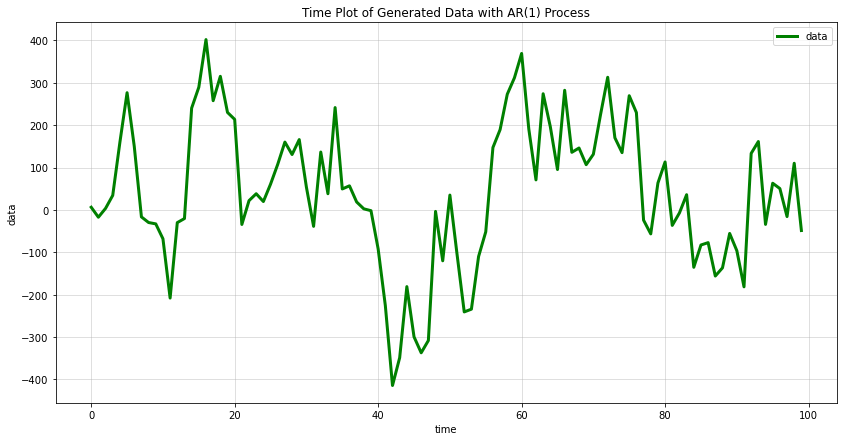

In [3]:
# generate time plot
def generate_time_plot(x1, y1, x2=None, y2=None, overlay=False, title="Time Plot", label2=None, xlabel="time", ylabel="data"):
    """
    Display a time plot of x1 versus y1 with the respective x-axis and y-axis labels.
    If overlay is True, x2 and y2 arguments need to be supplied to plot an overlay time plot.
    """
    plt.figure(figsize=(14,7))
    plt.plot(x1, y1, 'k-', label="data", color='green', linewidth=3)
    if overlay:
        plt.plot(x2, y2, 'b-', label=label2, color='red', linewidth=4)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.5)
    plt.legend();
    
generate_time_plot(time_steps, simulated_ar_1, title="Time Plot of Generated Data with AR(1) Process")

### Partial Autocorrelation Function (PACF)
Partial Autocorrelation function (PACF) plot can be generated using `statsmodels` API in one simple line.

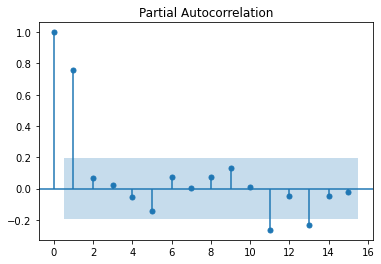

In [4]:
plot_pacf(simulated_ar_1, lags=range(0,16), alpha=0.05);

There are a few things to note when one attempts to interpret this plot, which is listed below:

1. **Blue region** -> confidence interval which can be set by varying the parameter of alpha. In this plot it is set to 0.05, meaning 95% confidence interval.
2. **Stems/Bars** -> lagged partial correlation values. 
3. **Stems/Bars outside of blue region** -> correlations that are statistically significant. The number of bars that lie outside the blue region are considered as an indication to choosing *p* order in the autoregressive (AR) model. In this case, only the lag-1 bar, lag-11 bar and the lag-13 has significant partial correlation with the current endogenous values.

Stationarity is not a pre-requisite for building AR model. Nonetheless, we can use Adjusted Dickey Fuller (ADF) test to inspect the stationarity of time series.

## <a name="ar">Autoregressive (AR) Model</a>
After performing some basic analytics on the dataset at hand, it's time to turn our main course tonight, autoregressive (AR) model.

The biggest disntinction between AR models and MA models lies in this: <br>
`MA models regress on past forecast errors in order to forecast future values while AR models regress on actual past values.`
<br>
<br>
A general formula for **AR** model is this:
<br>
<br>
<div style="text-align: center;">$y_t =  \beta_1y_{t-1}+...+\beta_{p}y_{t-p}+\epsilon_t$</div>
<br>
<br>
where $\epsilon$ is irreducible error, $\beta_n$ is the coefficient for the lagged terms, and $y_{t-p}$ are the lagged terms, with p indicating the order of lag.
<br>
<br>
That said, for a AR(1) process, the equation is as below:
<br>
<br>
<div style="text-align: center;">$y_t = \beta_1y_{t-1}+\epsilon_t$</div>
<br>
<br>
The equation for a AR(2) process is: 
<br>
<br>
<div style="text-align: center;">$y_t = \beta_1y_{t-1}+\beta_2y_{t-2}+\epsilon_t$</div>
<br>
<br>
... and so on. Basically a AR model with higher <i>p</i> order entails the addition of extra lagged terms. A suitable value for <i>p</i> can be determined using PACF plot which was introduced earlier.

We will be using `statsmodels` module extensively for building AR model. You can read more about the module [here](https://www.statsmodels.org/).

AR(1)
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  100
Model:                     ARMA(1, 0)   Log Likelihood                -612.522
Method:                       css-mle   S.D. of innovations            110.191
Date:                Fri, 26 Mar 2021   AIC                           1231.044
Time:                        16:01:29   BIC                           1238.859
Sample:                             0   HQIC                          1234.207
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.5071     42.138      0.914      0.361     -44.082     121.096
ar.L1.y        0.7458      0.065     11.481      0.000       0.618       0.873
                                    Roots     

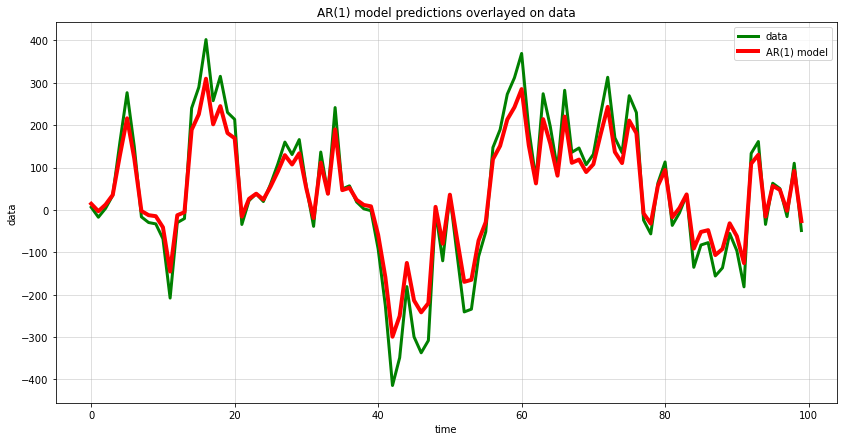

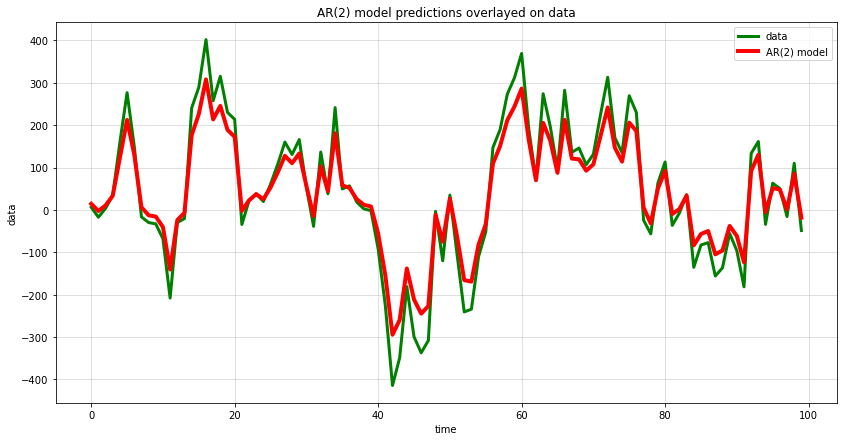

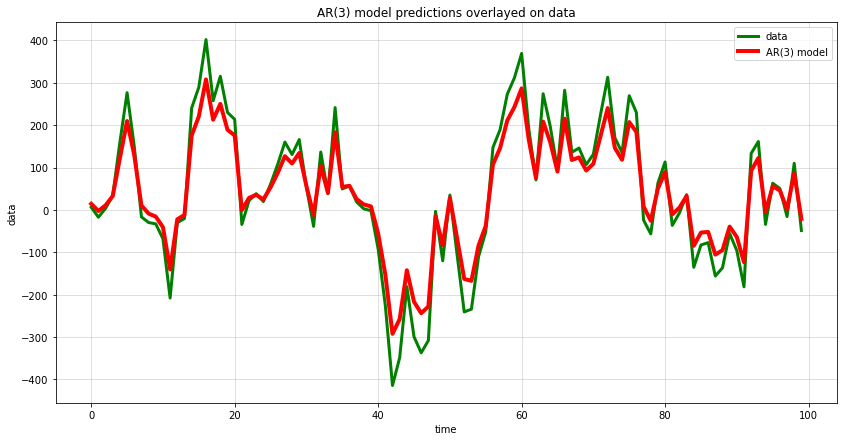

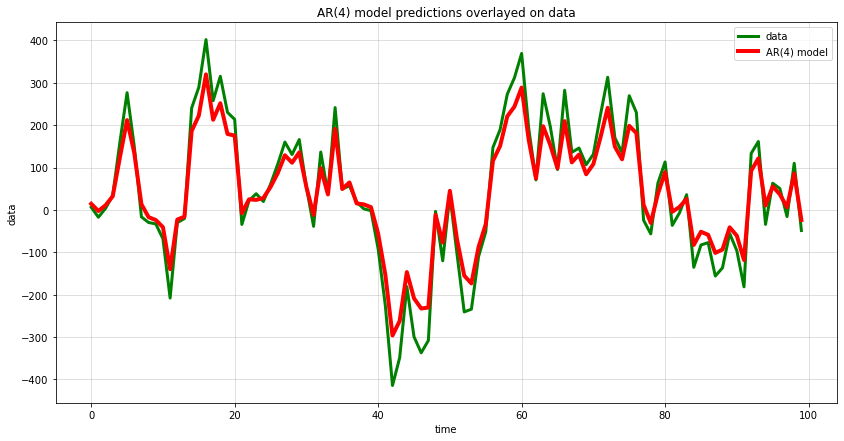

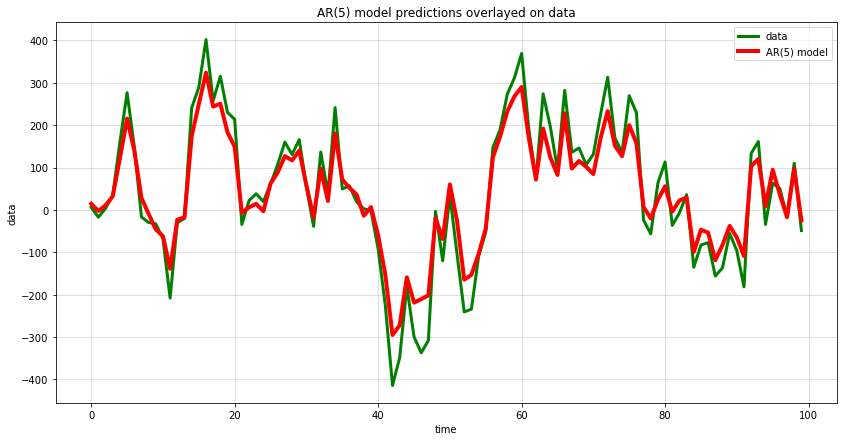

In [5]:
# plot different orders (p's)
for p in range(1,6):
    model = ARMA(simulated_ar_1, (p,0)).fit()
    generate_time_plot(time_steps, simulated_ar_1, time_steps, model.predict(start=1, end=100), overlay=True, 
                   title=f"AR({p}) model predictions overlayed on data", label2=f"AR({p}) model")
    print(f"AR({p})")
    print(model.summary())
    print("\n\n")

It seems that whichever order that we use for AR model will also allow for a close fit with the data. One objective way of checking which order parameter is the best is by using Akaike Information Criteria (AIC). Nevertheless, based on the ACF plot in previous section, we see that only lag-1, lag-11 and lag-13 values have a significant correlation with the current endogeneous value. This suggests that a suitable parameter for *p* could be 1.

### <a name="ar-2">AR(2) Model</a>

Recall the equation for a AR(2) process is: 
<br>
<div style="text-align: center;">$y_t = \beta_1y_{t-1}+\beta_2y_{t-2}+\epsilon_t$</div>
<br>
where $\epsilon$ is irreducible error, $\beta_n$ is the coefficient for the lagged terms, and $y_{t-p}$ are the lagged terms, with p indicating the order of lag.

In [6]:
# simulate AR(2) process
np.random.seed(38)
arparams = np.array([.75, -.55])
ar_2 = np.r_[1, -arparams]
simulated_ar_2 = ArmaProcess(ar=ar_2).generate_sample(nsample=100)

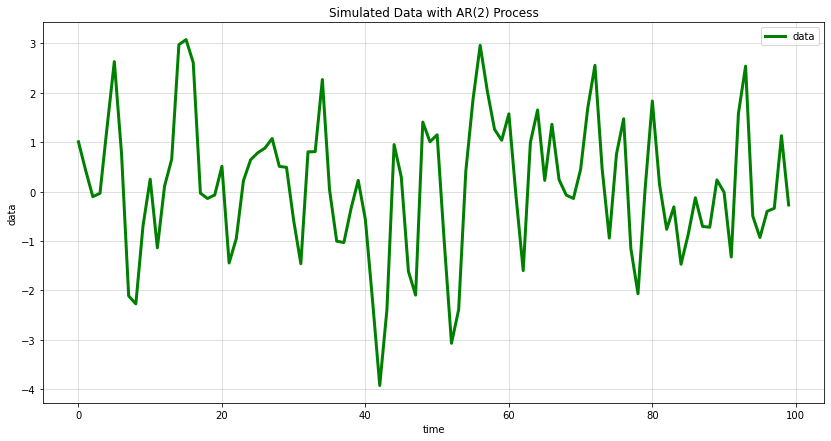

In [7]:
# plot time plot for AR(3) process
generate_time_plot(time_steps, simulated_ar_2, title="Simulated Data with AR(2) Process")

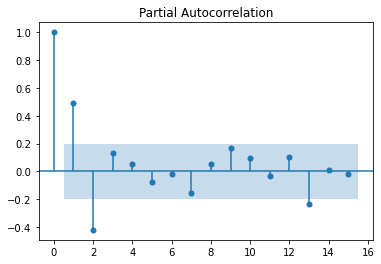

In [8]:
# plot PACF for AR(2)
plot_pacf(simulated_ar_2, lags=range(0,16), alpha=0.05);

### <a name="ar-3">AR(3) Model</a>

Likewise, the equation for a AR(3) process is: 
<br>
<div style="text-align: center;">$y_t = \beta_1y_{t-1}+\beta_2y_{t-2}+\beta_3y_{t-3}+\epsilon_t$</div>
<br>
where $\epsilon$ is irreducible error, $\beta_n$ is the coefficient for the lagged terms, and $y_{t-p}$ are the lagged terms, with p indicating the order of lag.

In [9]:
# simulate AR(3) process
np.random.seed(38)
arparams = np.array([.75, -.55, .30])
ar_3 = np.r_[1, -arparams]
simulated_ar_3 = ArmaProcess(ar_3).generate_sample(nsample=100)

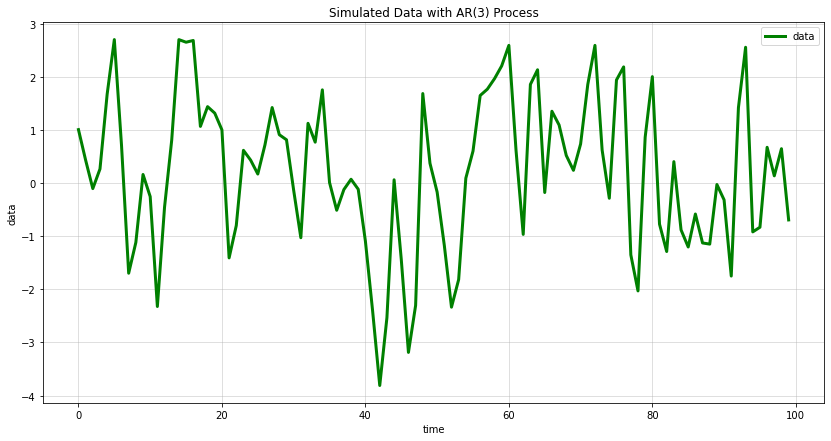

In [10]:
# plot time plot for AR(3) process
generate_time_plot(time_steps, simulated_ar_3, title="Simulated Data with AR(3) Process");

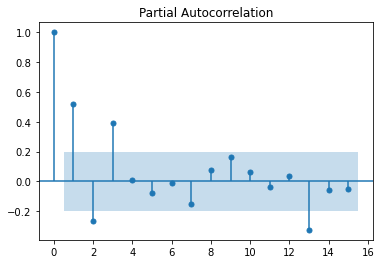

In [11]:
plot_pacf(simulated_ar_3, lags=range(0,16), alpha=0.05);

## <a name="exercise">Exercise</a>

This exercise section is attached for you to practice and hone your skills. Try your best effort to complete it without referring to the solution.

### Notebook Configurations
**INSTRUCTIONS**: You can import any module that you wish to use for this exercise. However, if you run the cells from the start of this notebook, most probably all the modules which you need had already been imported at this point.

In [12]:
# import modules
### BEGIN SOLUTION


### END SOLUTION

### Dataset
**INSTRUCTIONS**: Please load the dataset into the environment using the path specified for you.

In [13]:
# specified path
dataset_path = Path().resolve().parent.parent/"datasets/others"
filename = "furniture-sales.csv"

In [14]:
# import dataset using specified path and filename above
### BEGIN SOLUTION

### END SOLUTION

### Basic Analytics and PACF
**INSTRUCTIONS**: Perform some basic analytics on the dataset by following the guidelines that are provided in each cell.

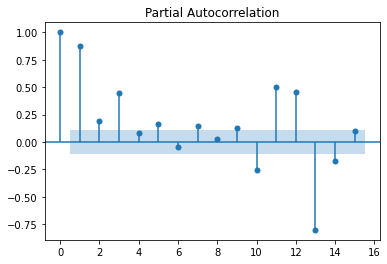

In [15]:
# generate PACF plot
### BEGIN SOLUTION

### END SOLUTION

### AR Model
**INSTRUCTIONS**: Fit AR model using the provided data.

AR(1)
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  336
Model:                     ARMA(1, 0)   Log Likelihood               -2716.578
Method:                       css-mle   S.D. of innovations            783.455
Date:                Fri, 26 Mar 2021   AIC                           5439.155
Time:                        16:01:33   BIC                           5450.607
Sample:                             0   HQIC                          5443.720
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7586.8195    396.688     19.125      0.000    6809.326    8364.313
ar.L1.y        0.8949      0.025     35.362      0.000       0.845       0.944
                                    Roots     

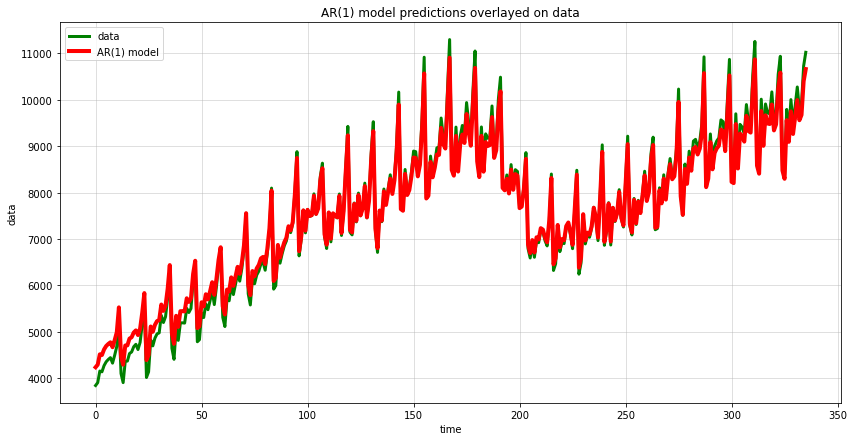

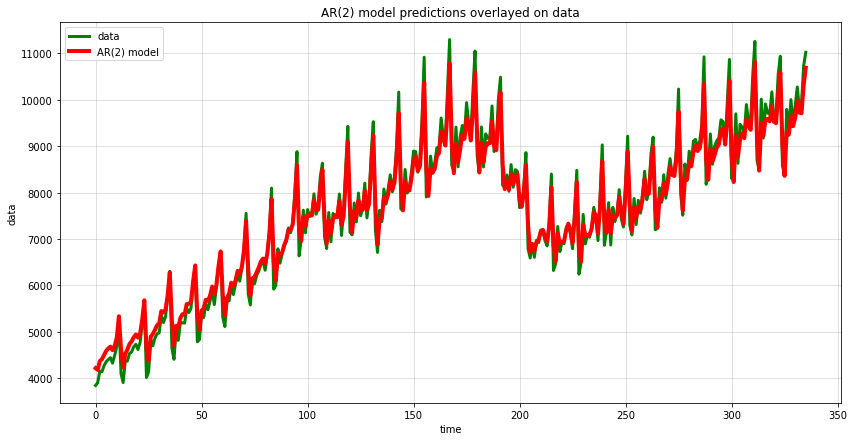

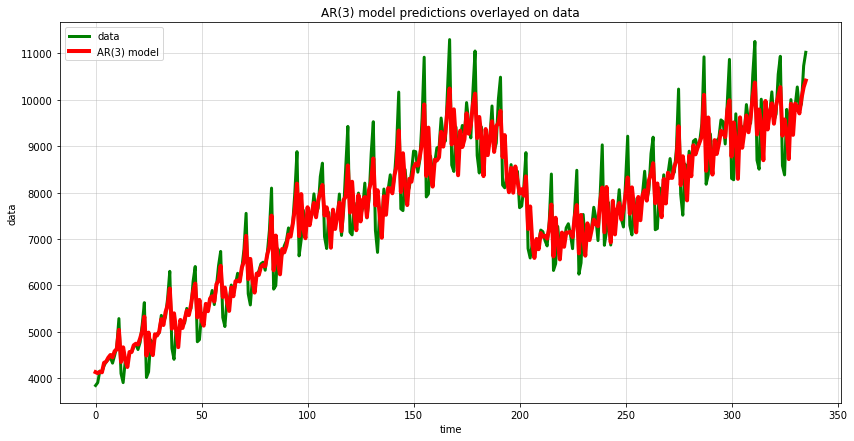

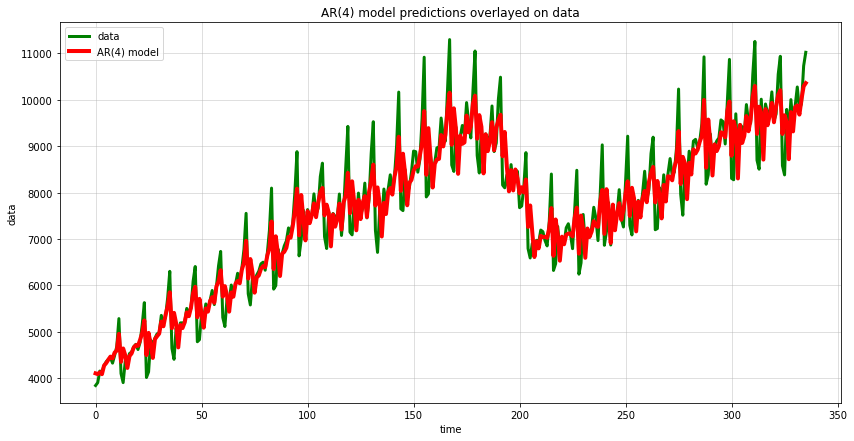

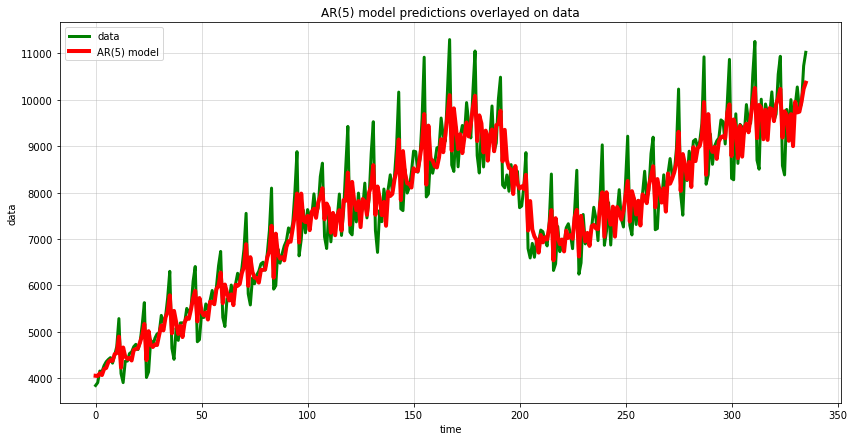

In [16]:
# build AR model by iterating through a list of p-order parameters
### BEGIN SOLUTION








### END SOLUTION

## <a name="reference">Reference</a>
1. [Statsmodels](www.statsmodels.org)
2. [Time Series Forecasting with Autoregressive Processes](https://towardsdatascience.com/time-series-forecasting-with-autoregressive-processes-ba629717401)

## <a name="bonus">Bonus</a>
Opposing to the moving average (MA) model, stationarity is not a pre-requisite for AR model as it may contain a unit root.